In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# Location changes for given momenta
def deltaQ(P, masses, timeStepSize):
    return np.array([(timeStepSize * (P[i] / masses[i])).tolist() for i in range(len(masses))])

# Momentum changes (under gravity) for given locations
def deltaP(Q, masses, timeStepSize):
    # Hack: steal dimension/structure of Q (as python is a little b**** and wont tell me)
    P = np.copy(Q)
    P[:] = 0
    
    numObjs = len(masses)
    for i in range(numObjs):
        for j in range(i):
            interObjDir = Q[j] - Q[i]
            interObjMag = (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**1.5
            delta = (2.95912208286e-4*masses[j]*masses[i]/interObjMag)*interObjDir
            P[i] += timeStepSize * delta
            P[j] -= timeStepSize * delta
    
    return P

In [3]:
#----------------------------------------------------------------------------------------------
def explicitEuler(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newQ += deltaQ(oldP, masses, timeStepSize)
    newP += deltaP(oldQ, masses, timeStepSize)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerA(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newQ += deltaQ(oldP, masses, timeStepSize)
    newP += deltaP(newQ, masses, timeStepSize)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerB(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newP += deltaP(oldQ, masses, timeStepSize)
    newQ += deltaQ(newP, masses, timeStepSize)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def symplecticEulerAB(oldQ, oldP, masses, timeStepSize):
    newQA, newPA = symplecticEulerA(oldQ, oldP, masses, timeStepSize)
    newQB, newPB = symplecticEulerB(oldQ, oldP, masses, timeStepSize)
    newQ = (newQA + newQB) / 2.0
    newP = (newPA + newPB) / 2.0
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def stormerVerletA(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newP += deltaP(oldQ, masses, timeStepSize/2)
    newQ += deltaQ(newP, masses, timeStepSize)
    newP += deltaP(newQ, masses, timeStepSize/2)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def stormerVerletB(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newQ += deltaQ(oldP, masses, timeStepSize/2)
    newP += deltaP(newQ, masses, timeStepSize)
    newQ += deltaQ(newP, masses, timeStepSize/2)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------
def midPoint(oldQ, oldP, masses, timeStepSize):
    newQ = np.copy(oldQ)
    newP = np.copy(oldP)
    
    newQEst, newPEst = explicitEuler(oldQ, oldP, masses, timeStepSize)
    midQEst = (oldQ + newQEst) / 2.0
    midPEst = (oldP + newPEst) / 2.0
    
    newQ += deltaQ(midPEst, masses, timeStepSize)
    newP += deltaP(midQEst, masses, timeStepSize)
    
    return newQ, newP
#----------------------------------------------------------------------------------------------

In [4]:
#----------------------------------------------------------------------------------------------
# Model parameters
numberTimeSteps = 20000
timeStepSize = 10.0
updateFn = midPoint
#----------------------------------------------------------------------------------------------
# Model data 
# Masses in (solar mass) stored in masses, displacement in (AU) stored in q, momentum in (AU * SM / per Day) stored in p 
names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
colours = ['#A60303', '#725752', '#F5853F', '#82A0BC', '#19323C', '#91948C']
numObjs = len(names)
masses = [1.00000597682, 9.54786104043e-4, 2.85583733151e-4, 4.37273164546e-5, 5.17759138449e-5, 1/(1.3e8)]
q = np.array(
    [[0,0,0],
    [-3.5023653,-3.8169847,-1.5507963],
    [9.0755314,-3.0458353,-1.6483708],
    [8.3101420, -16.2901086, -7.2521278],
    [11.4707666, -25.7294829, -10.8169456],
    [-15.5387357, -25.2225594, -3.1902382]])
v = np.array(
    [[0,0,0],
    [0.00565429, -0.00412490, -0.0019058],
    [0.00168318, 0.00483525, 0.00192462],
    [0.00354178, 0.00137102, 0.00055029],
    [0.00288930, 0.00114527, 0.00039677],
    [0.00276725, -0.00170702, -0.00136504]])
#----------------------------------------------------------------------------------------------
# Set system momentum to 0
p = np.array([(masses[i]*v[i]).tolist() for i in range(numObjs)])
totMomentum = sum(p)
totMass = sum(masses)
deltaV = -1/totMass * totMomentum
#----------------------------------------------------------------------------------------------
p = np.array([(masses[i]*(v[i] + deltaV)).tolist() for i in range(numObjs)])

In [5]:
# Store for plotting
qStored = np.empty((numberTimeSteps,numObjs,3))
qStored[:] = np.nan
pStored = np.empty((numberTimeSteps,numObjs,3))
pStored[:] = np.nan

# Main loop
for i in range(numberTimeSteps):
    q, p = updateFn(q, p, masses, timeStepSize)
    
    qStored[i] = q
    pStored[i] = p
    
    # Progress tracker
    if ((i+1)%int(numberTimeSteps/100) == 0):
        print("{}% has been completed".format((i+1)*100/numberTimeSteps), end = "\r")

In [6]:
energies = np.empty((numberTimeSteps,numObjs + 1,4))
energies[:] = np.nan

for i in range(numberTimeSteps):
    for j in range(numObjs):
        # KE in 0th slot
        energies[i,j,0] = (0.5 / masses[j]) * (pStored[i,j,0]**2 + pStored[i,j,1]**2 + pStored[i,j,2]**2)
        
        # GPE in 1st slot
        gravE = 0.0
        for k in range(numObjs):
            if (k != j):
                interObjDir = qStored[i,j] - qStored[i,k]
                gravE += 2.95912208286e-4 * masses[j] * masses[k] / (interObjDir[0]**2 + interObjDir[1]**2 + interObjDir[2]**2)**0.5
        
        energies[i,j,1] = gravE
        
        # TE in 2nd slot
        energies[i,j,2] = energies[i,j,0] + energies[i,j,1]
        
        # Norm TE in 3rd slot
        energies[i,j,3] = energies[i,j,2] / energies[0,j,2]
    
    # System data
    energies[i,numObjs,0] = np.sum(energies[i,0:numObjs,0])
    energies[i,numObjs,1] = np.sum(energies[i,0:numObjs,1])
    energies[i,numObjs,2] = energies[i,numObjs,0] + energies[i,numObjs,1]
    energies[i,numObjs,3] = energies[i,numObjs,2] / energies[0,numObjs,2]
    
    # Progress tracker
    if ((i+1)%int(numberTimeSteps/100) == 0):
        print("{}% has been completed".format((i+1)*100/numberTimeSteps), end = "\r")

In [7]:
# Plotting parameters
# plt.xkcd()
plotStepSize = 1
plotRange = numberTimeSteps
cropPlotRange = range(0, plotRange, plotStepSize)

<IPython.core.display.Javascript object>


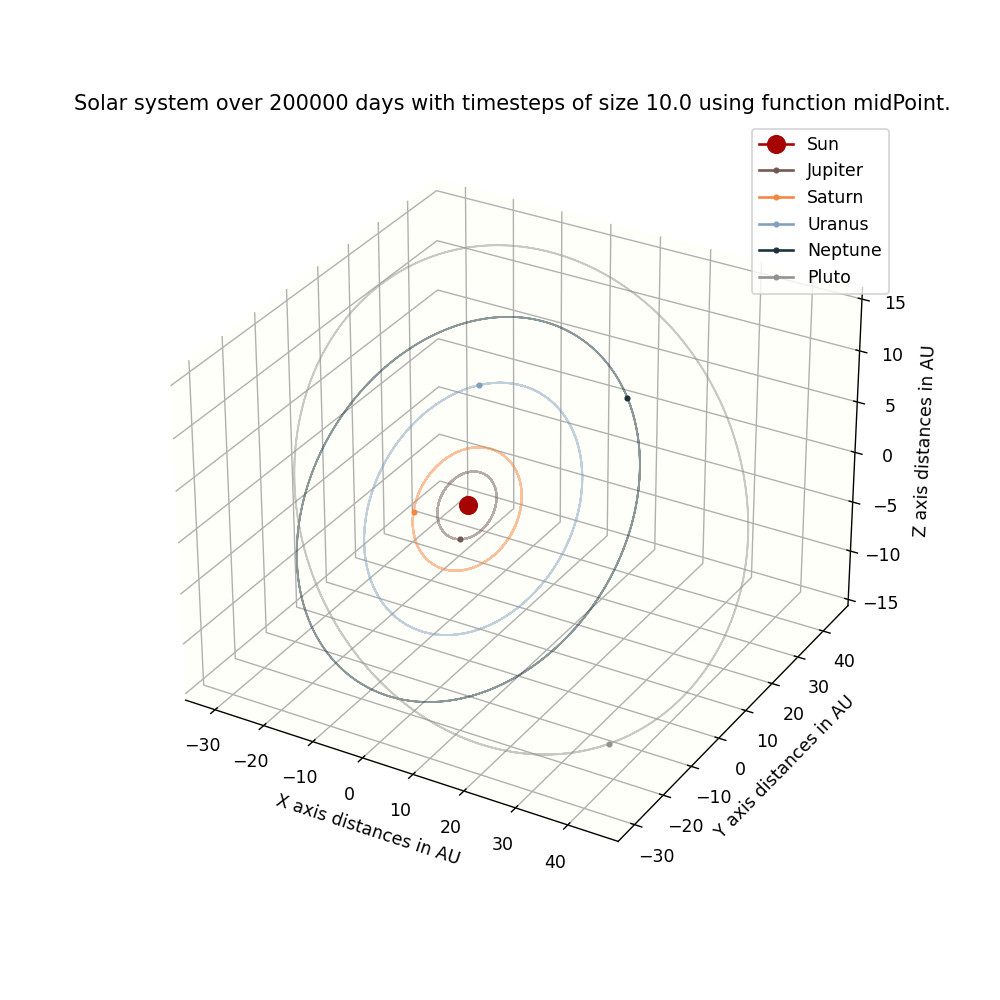

Text(0.5, 0, 'Z axis distances in AU')

In [8]:
figOrbit = plt.figure(figsize=(8, 8))
figOrbit.add_subplot(projection='3d')

ax = figOrbit.gca()
for j in range(numObjs):
    ax.plot(qStored[cropPlotRange[-1]][j][0], qStored[cropPlotRange[-1]][j][1], qStored[cropPlotRange[-1]][j][2], color = colours[j], marker = ('o' if j==0 else '.'), markersize = (10 if j==0 else 5), label = names[j])
    ax.plot(qStored[cropPlotRange,j,0], qStored[cropPlotRange,j,1], qStored[cropPlotRange,j,2], color = colours[j], marker = '', linestyle='-', alpha = 0.5, linewidth = 1)

ax.w_xaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
ax.legend()
titleStr = "Solar system over {} days with timesteps of size {} using function {}.".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
ax.set_title(titleStr)
labelStr = " axis distances in AU"
ax.set_xlabel("X" + labelStr)
ax.set_ylabel("Y" + labelStr)
ax.set_zlabel("Z" + labelStr)
# plt.savefig('Orbits.svg', dpi=2400)

<IPython.core.display.Javascript object>


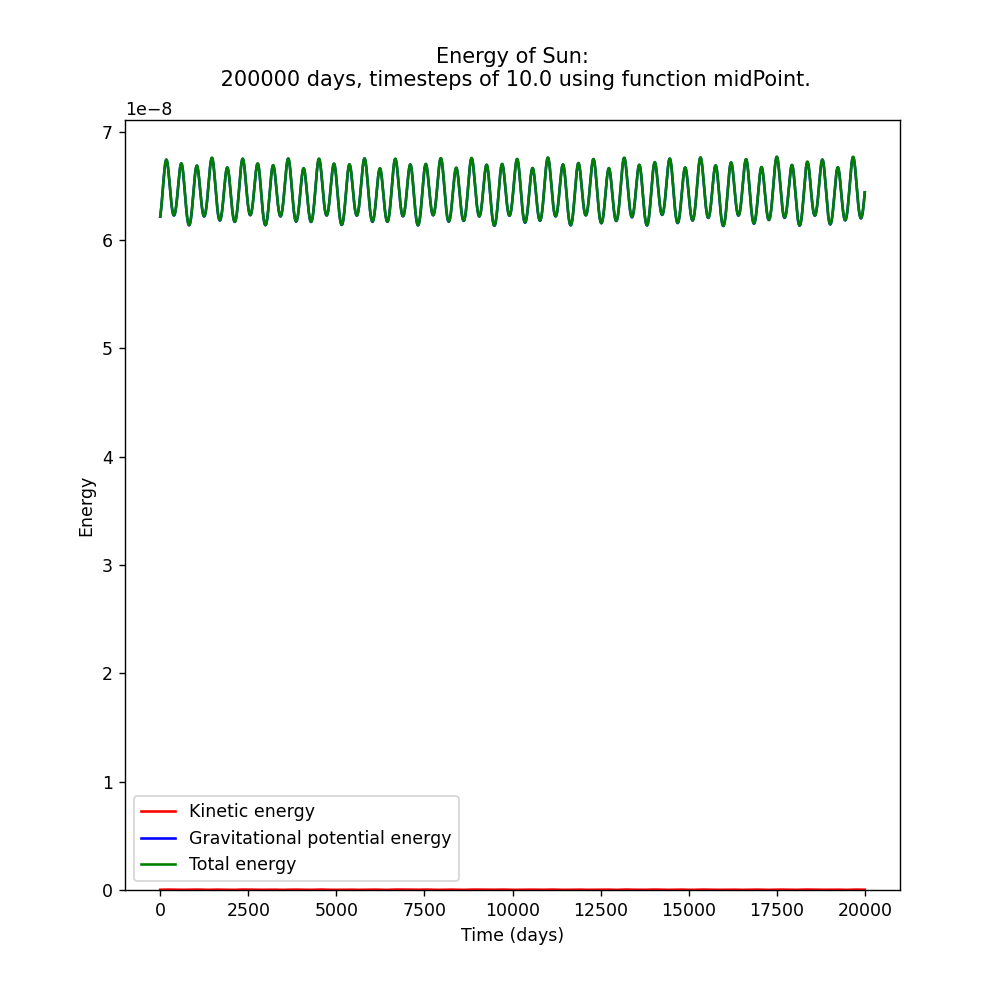

<IPython.core.display.Javascript object>


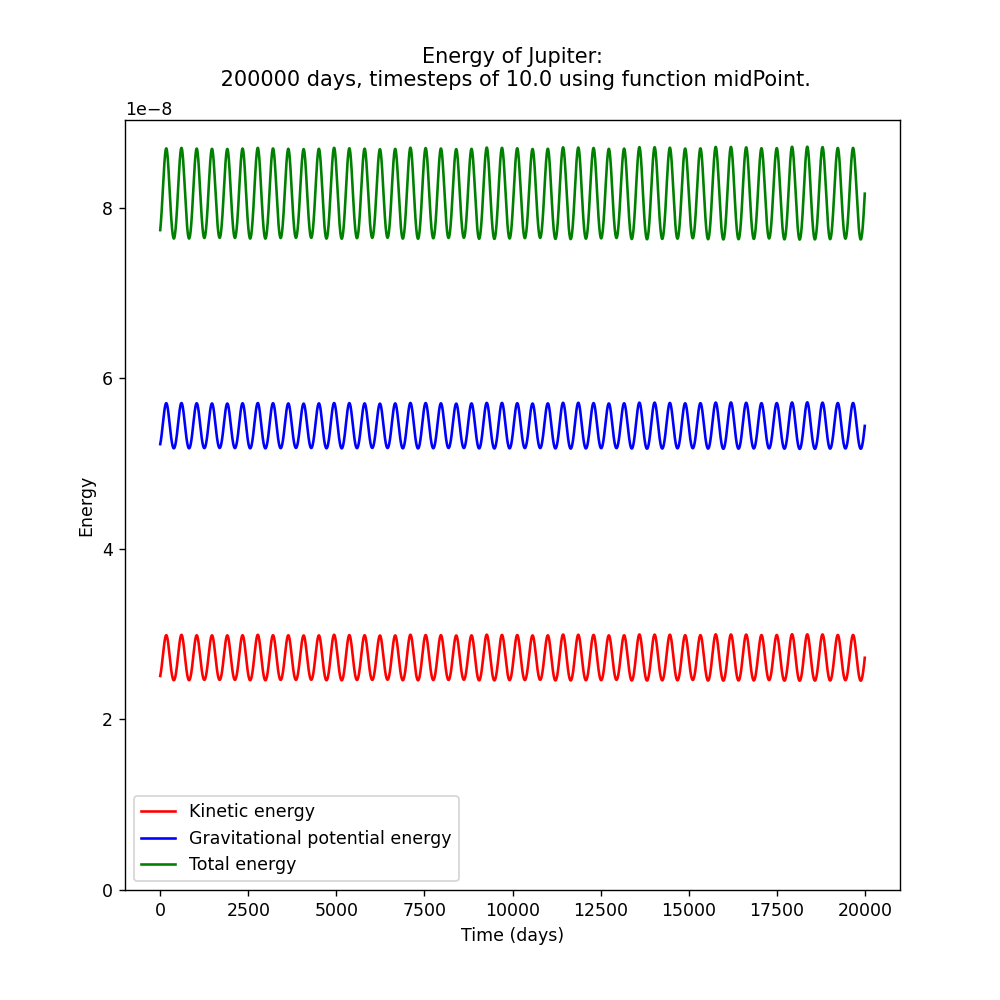

<IPython.core.display.Javascript object>


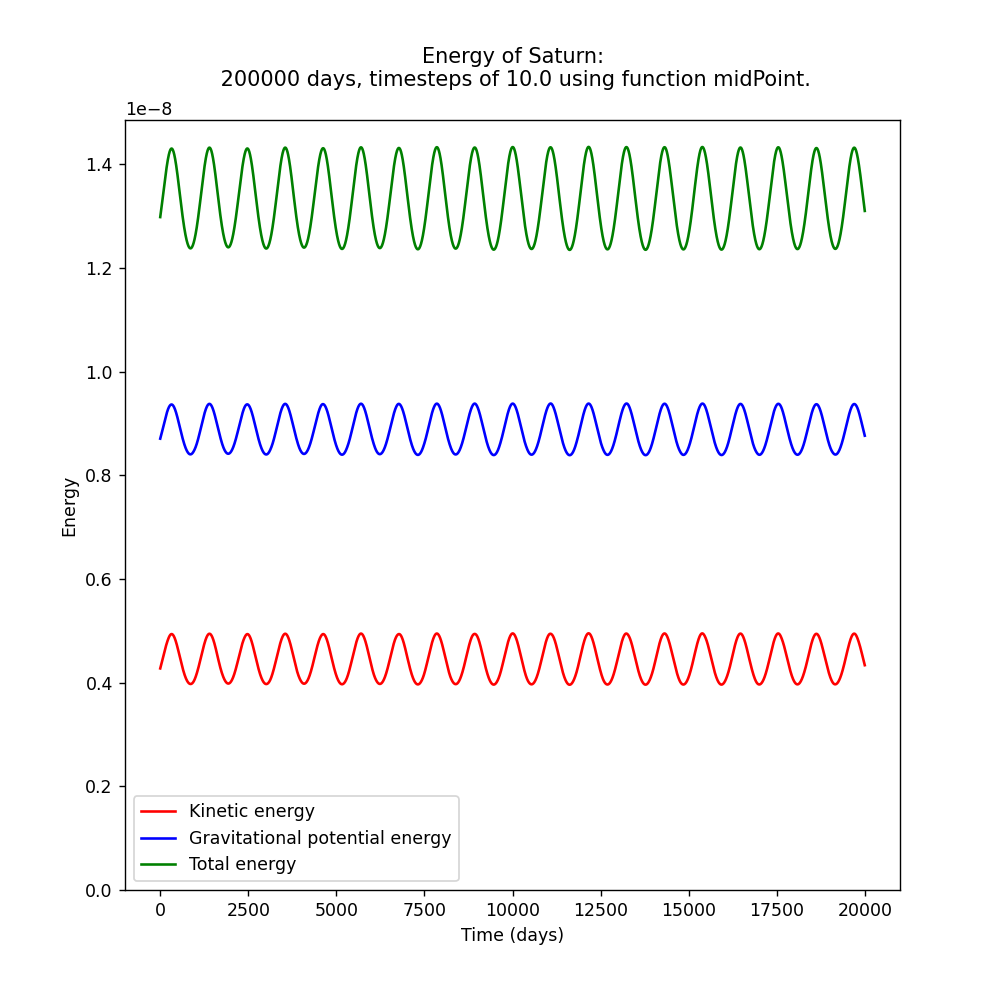

<IPython.core.display.Javascript object>


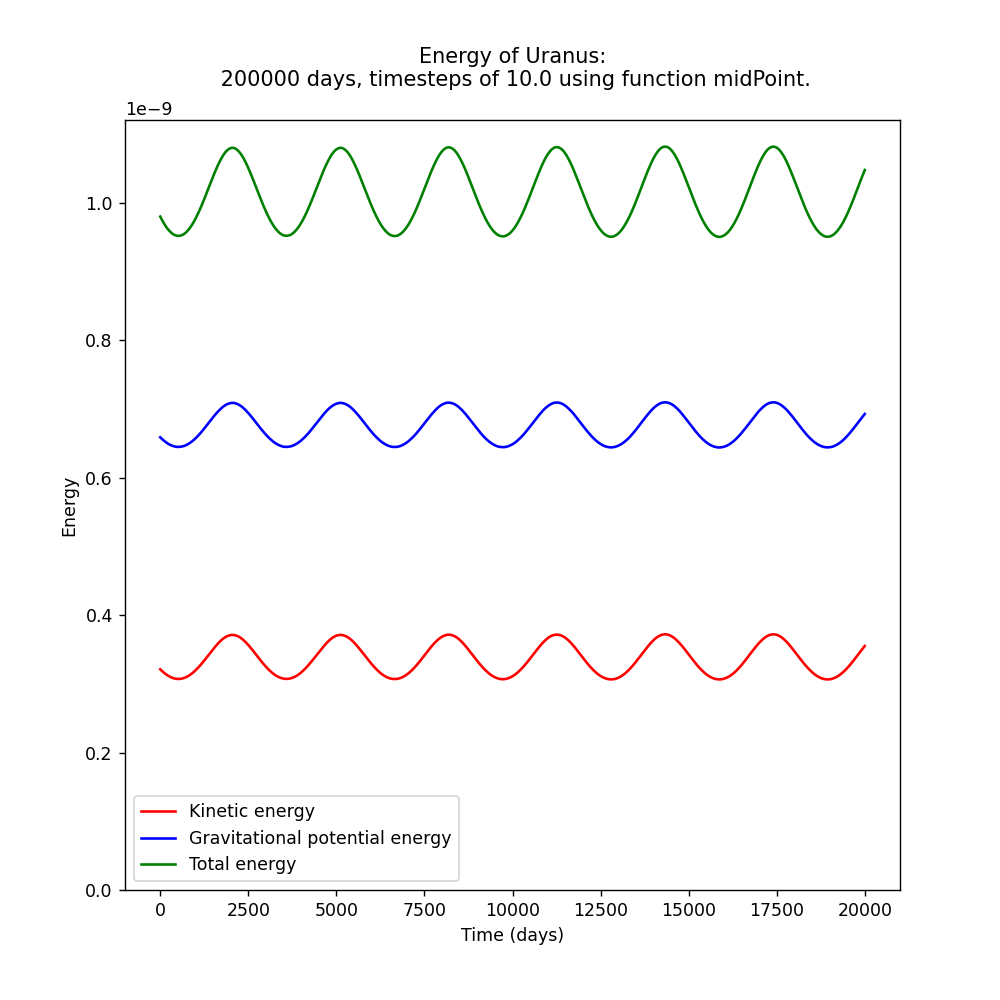

<IPython.core.display.Javascript object>


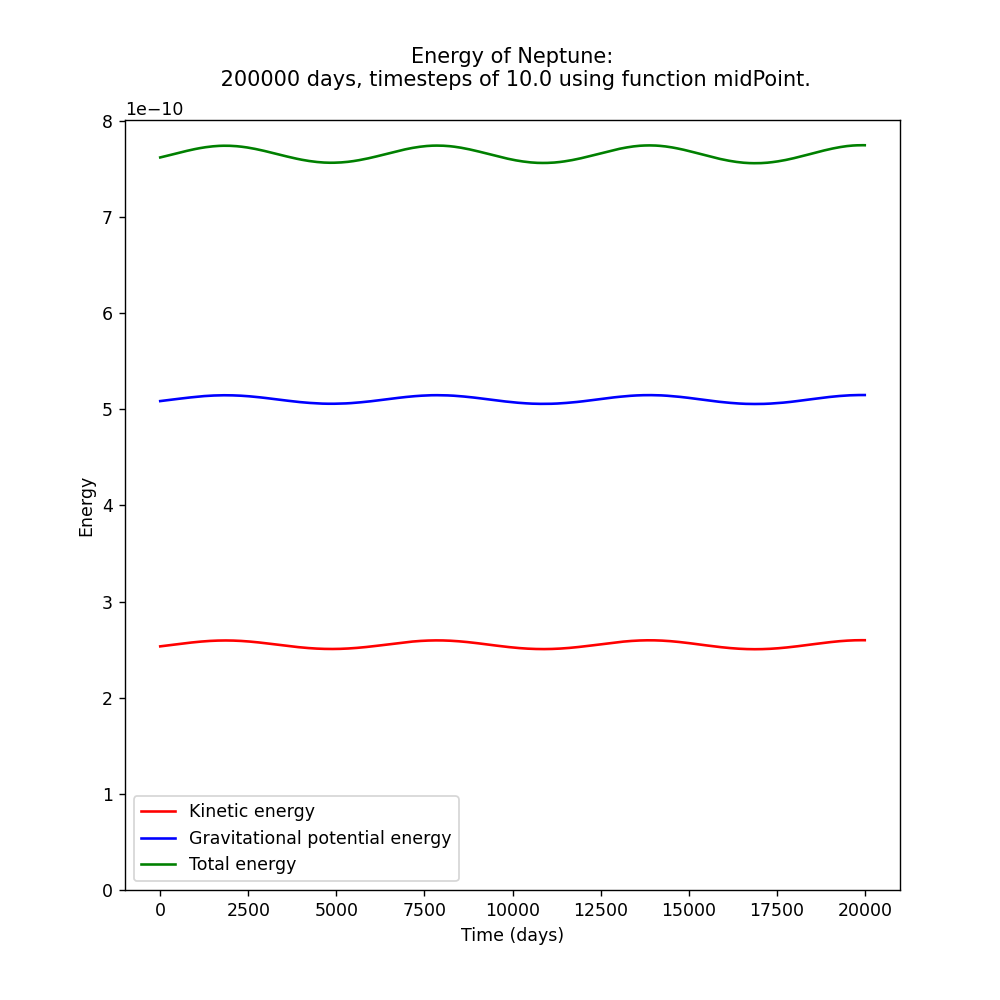

<IPython.core.display.Javascript object>


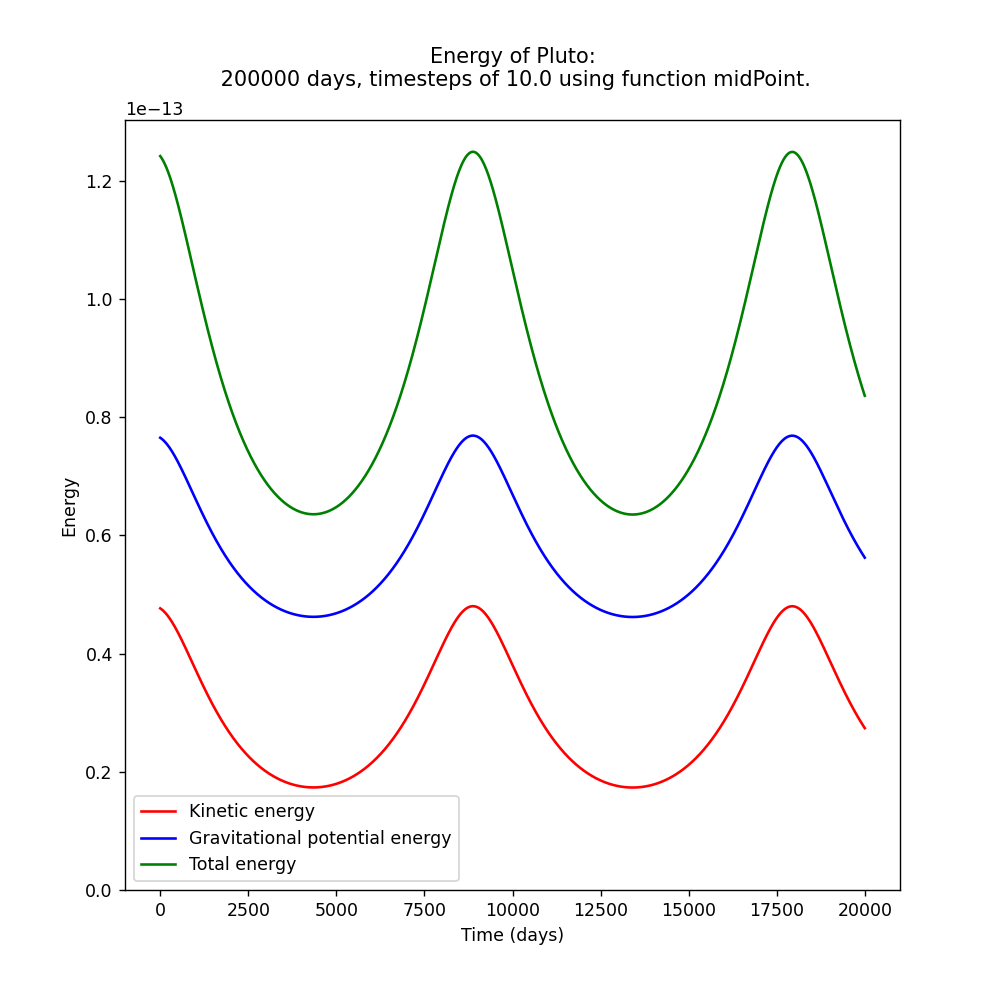

<IPython.core.display.Javascript object>


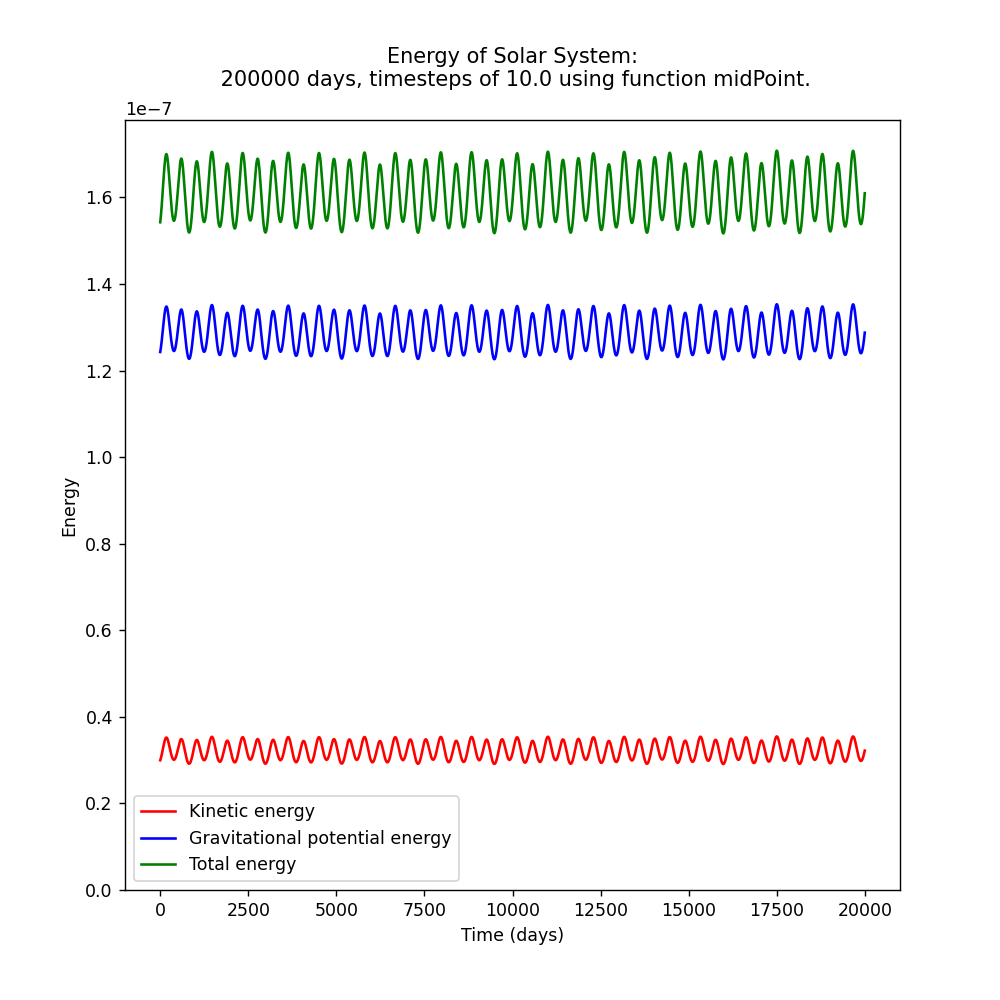

In [9]:
for i in range(numObjs + 1):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()
    ke = energies[cropPlotRange,i,0]
    gpe = energies[cropPlotRange,i,1]
    te = energies[cropPlotRange,i,2]
    ax.plot(cropPlotRange, ke, color = 'red', marker = '', linestyle='-', label = "Kinetic energy")
    ax.plot(cropPlotRange, gpe, color = 'blue', marker = '', linestyle='-', label = "Gravitational potential energy")
    ax.plot(cropPlotRange, te, color = 'green', marker = '', linestyle='-', label = "Total energy")
    ax.legend()
    titleStr = "Energy of {}:\n {} days, timesteps of {} using function {}.\n".format(("Solar System" if i==numObjs else names[i]), int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
    ax.set_title(titleStr)
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Energy")
    ax.set_ylim(bottom=0.0)

<IPython.core.display.Javascript object>


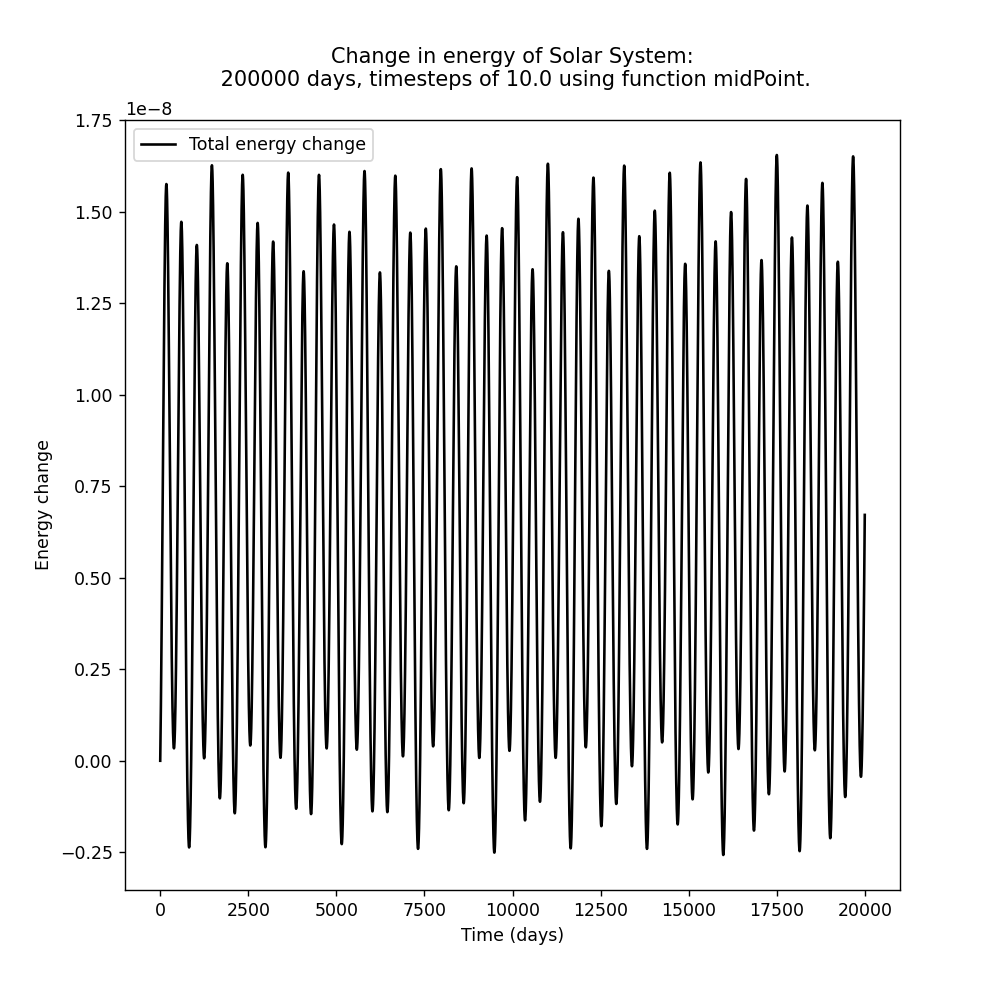

Text(0, 0.5, 'Energy change')

In [10]:
figEnDel = plt.figure(figsize=(8, 8))
ax = figEnDel.gca()
teDelta = energies[cropPlotRange,numObjs,2] - energies[0,numObjs,2]
ax.plot(cropPlotRange, teDelta, color = 'black', marker = '', linestyle='-', label = "Total energy change")
ax.legend()
titleStr = "Change in energy of Solar System:\n {} days, timesteps of {} using function {}.\n".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
ax.set_title(titleStr)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Energy change")

<IPython.core.display.Javascript object>


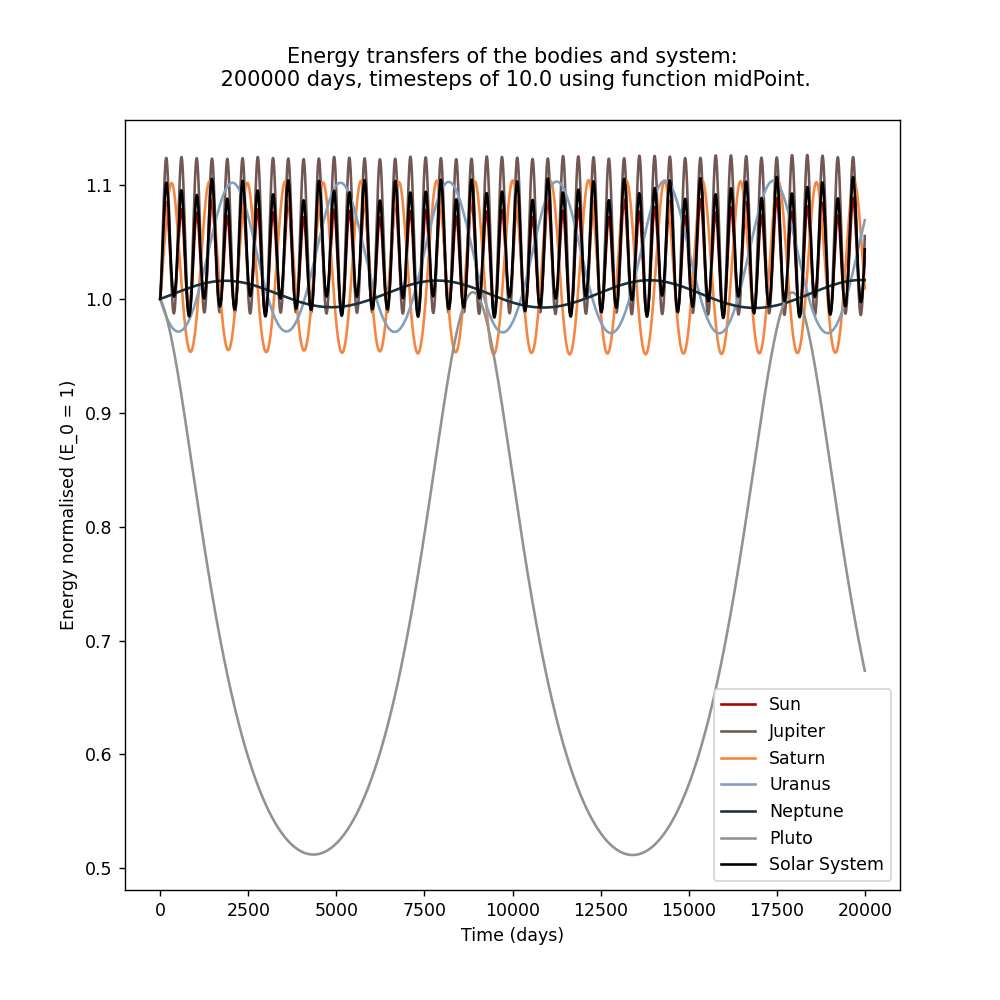

Text(0, 0.5, 'Energy normalised (E_0 = 1)')

In [11]:
figEnRel = plt.figure(figsize=(8, 8))
ax = figEnRel.gca()

for i in range(numObjs+1):
    teNorm = energies[cropPlotRange,i,3]
    ax.plot(cropPlotRange, teNorm, color = ('black' if i==numObjs else colours[i]), marker = '', linestyle='-', label = ("Solar System" if i==numObjs else names[i]))

ax.legend()
titleStr = "Energy transfers of the bodies and system:\n {} days, timesteps of {} using function {}.\n".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
ax.set_title(titleStr)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Energy normalised (E_0 = 1)")

In [12]:
# figAnim = plt.figure(figsize=(8, 8))
# figAnim.add_subplot(projection='3d')
# ax = figAnim.gca()
# ln, = plt.plot([], [], [], color = '#91948C', marker = '', linestyle='-', alpha = 0.5, linewidth = 1, label = "Pluto")

# def init():
#     ax.set_xlim(-45.0, 45.0)
#     ax.set_ylim(-45.0, 45.0)
#     ax.set_zlim(-45.0, 45.0)
#     ax.w_xaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.w_yaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.w_zaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.legend()
#     titleStr = "Solar system over {} days with timesteps of size {} using function {}.".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
#     ax.set_title(titleStr)
#     labelStr = " axis distances in AU"
#     ax.set_xlabel("X" + labelStr)
#     ax.set_ylabel("Y" + labelStr)
#     ax.set_zlabel("Z" + labelStr)
#     return ln,

# def update(frame, ln, qStored):
#     ln.set_data(qStored[:frame, numObjs - 1, 0], qStored[:frame, numObjs - 1, 1])
#     ln.set_3d_properties(qStored[:frame, numObjs - 1, 2])
#     return ln,

# ani = FuncAnimation(figAnim, update, frames = cropPlotRange[::100], init_func=init, blit=True, fargs=(ln, qStored))
# ani

In [13]:
# figAnim = plt.figure(figsize=(8, 8))
# figAnim.add_subplot(projection='3d')
# ax = figAnim.gca()
# lnPluto, = plt.plot([], [], [], color = '#91948C', marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
# dotPluto, = plt.plot([], [], [], color = '#91948C', marker = '.', markersize = 5, label = "Pluto")

# def init():
#     ax.set_xlim(-45.0, 45.0)
#     ax.set_ylim(-45.0, 45.0)
#     ax.set_zlim(-45.0, 45.0)
#     ax.w_xaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.w_yaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.w_zaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
#     ax.legend()
#     titleStr = "Solar system over {} days with timesteps of size {} using function {}.".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
#     ax.set_title(titleStr)
#     labelStr = " axis distances in AU"
#     ax.set_xlabel("X" + labelStr)
#     ax.set_ylabel("Y" + labelStr)
#     ax.set_zlabel("Z" + labelStr)
#     return lnPluto, dotPluto,

# # def update(frame, lnPluto, dotPluto, qStored):
# def update(frame):
#     lnPluto.set_data(qStored[:frame, numObjs - 1, 0], qStored[:frame, numObjs - 1, 1])
#     lnPluto.set_3d_properties(qStored[:frame, numObjs - 1, 2])
#     dotPluto.set_data(qStored[frame, numObjs - 1, 0], qStored[frame, numObjs - 1, 1])
#     dotPluto.set_3d_properties(qStored[frame, numObjs - 1, 2])
#     return lnPluto, dotPluto,
# #     return lnPluto, 

# # ani = FuncAnimation(figAnim,update,frames=cropPlotRange[::100],init_func=init,blit=True,fargs=(lnPluto,dotPluto,qStored))
# ani = FuncAnimation(figAnim,update,frames=cropPlotRange[::100],init_func=init,blit=True)
# ani

<IPython.core.display.Javascript object>


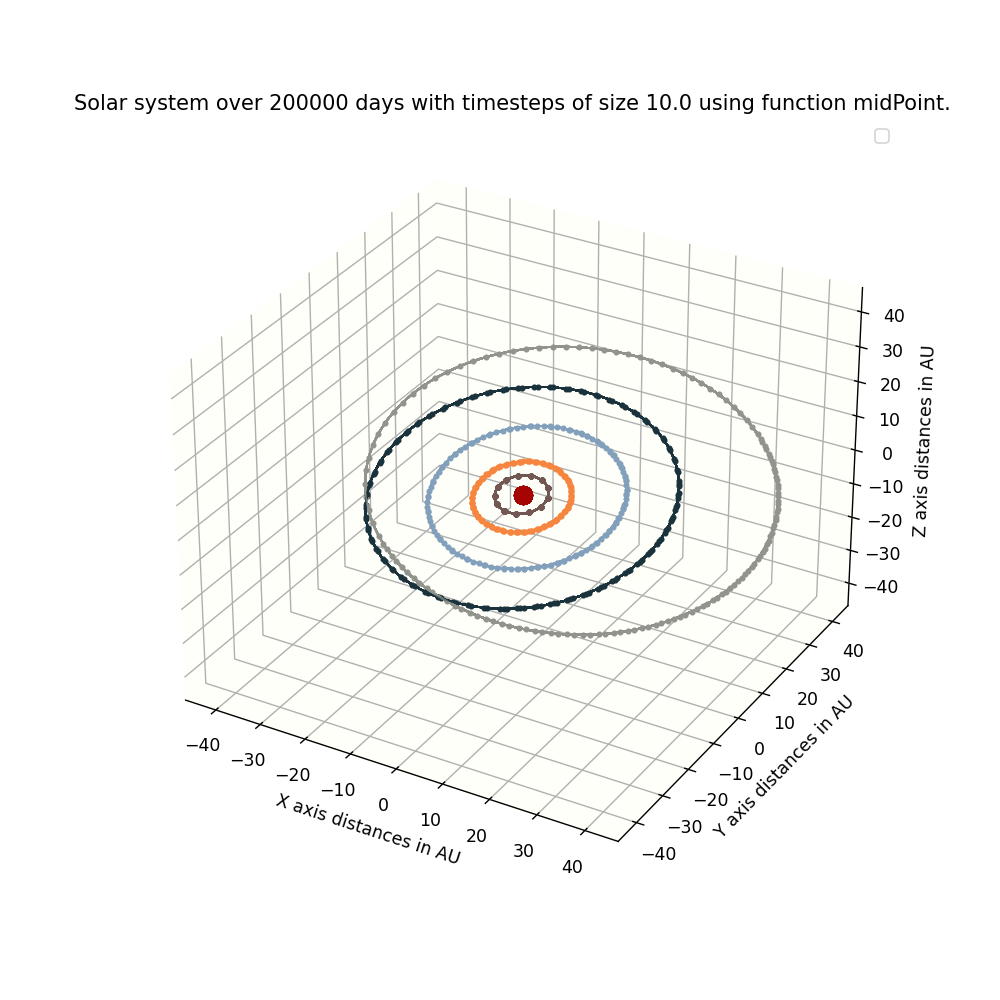

In [16]:
figAnim = plt.figure(figsize=(8, 8))
figAnim.add_subplot(projection='3d')
ax = figAnim.gca()
lines = []

def init():
    ax.set_xlim(-45.0, 45.0)
    ax.set_ylim(-45.0, 45.0)
    ax.set_zlim(-45.0, 45.0)
    ax.w_xaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 0.975, 1.0))
    ax.legend()
    titleStr = "Solar system over {} days with timesteps of size {} using function {}.".format(int(plotRange*timeStepSize), timeStepSize, updateFn.__name__)
    ax.set_title(titleStr)
    labelStr = " axis distances in AU"
    ax.set_xlabel("X" + labelStr)
    ax.set_ylabel("Y" + labelStr)
    ax.set_zlabel("Z" + labelStr)
    return

def update(frame, lines, qStored):
    lines = []
    for i in range(numObjs):
        line, = ax.plot(qStored[frame, i, 0], qStored[frame, i, 1], qStored[frame, i, 2], color = colours[i], marker = ('o' if i==0 else '.'), markersize = (10 if i==0 else 5), label = names[i])
        lines.append(line)
        line, = ax.plot(qStored[:frame, i, 0], qStored[:frame, i, 1], qStored[:frame, i, 2], color = colours[i], marker = '', linestyle='-', alpha = 0.5, linewidth = 1)
        lines.append(line)
    return lines,

ani = FuncAnimation(figAnim, update, frames = cropPlotRange[::100], init_func=init, blit=True, fargs=(lines, qStored))
ani